In [2]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
#from geopy.distance import great_circle
#from geopy.distance import geodesic
#import geopandas
#import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

%config InlineBackend.figure_formats = ['png']

In [1]:
#Get all bike data


#read csv files one at a time, because my computer crashes otherwise

#throw out almost all data, but keep count of the rides departing at each station on each day


input_df=pd.DataFrame()
bike_df=pd.DataFrame()
by_station_df=pd.DataFrame()
first=True
file_list=[]

#get file names
for filename in glob.iglob('citibike/combined/**.csv', recursive=True):
    file_list.append(filename)
    
#Sort to have the dataframe in order after assembling all files
file_list.sort()

#read csv files one at a time, because my computer crashes otherwise
for filename in file_list:
    if os.path.isfile(filename): # filter dirs
        input_df=pd.read_csv(filename)
        input_df.dropna(inplace=True)
        input_df['date'] = pd.to_datetime(input_df['starttime']).dt.date
        if first:
            #get station names from chronologically first data file, since there were fewer stations in the past
            station_names = list(set(input_df['start station name']))
            #get station locations
            station_locations=input_df.groupby(['start station name'])[[
                'start station latitude','start station longitude']].max().reset_index()
            station_locations.columns=['station','latitude','longitude']
        by_station_df = input_df[input_df['start station name'] == station_names[0]].groupby(['date'])\
        [['gender']].count().reset_index()
        by_station_df.columns=['date',station_names[0]]
        by_station_df.set_index('date')
        for name in station_names[1::]:
            by_station_df[name] = input_df[input_df['start station name'] == name].groupby(['date'])\
            [['gender']].count().reset_index()['gender']
            
        if first:
            bike_df=by_station_df
            first = False
        else:
            bike_df=bike_df.append(by_station_df)
bike_df.set_index('date',inplace=True)
with open('bike_df.pickle', 'wb') as to_write:
    pickle.dump(bike_df, to_write)
with open('station_names.pickle', 'wb') as to_write:
    pickle.dump(station_names, to_write)    
with open('station_locations.pickle', 'wb') as to_write:
    pickle.dump(station_locations, to_write)

NameError: name 'pd' is not defined

In [3]:
with open('bike_df.pickle','rb') as read_file:
    bike_df = pickle.load(read_file)
with open('station_names.pickle','rb') as read_file:
    station_names = pickle.load(read_file)
with open('station_locations.pickle','rb') as read_file:
    station_locations = pickle.load(read_file)

Text(0, 0.5, 'Rides per Day')

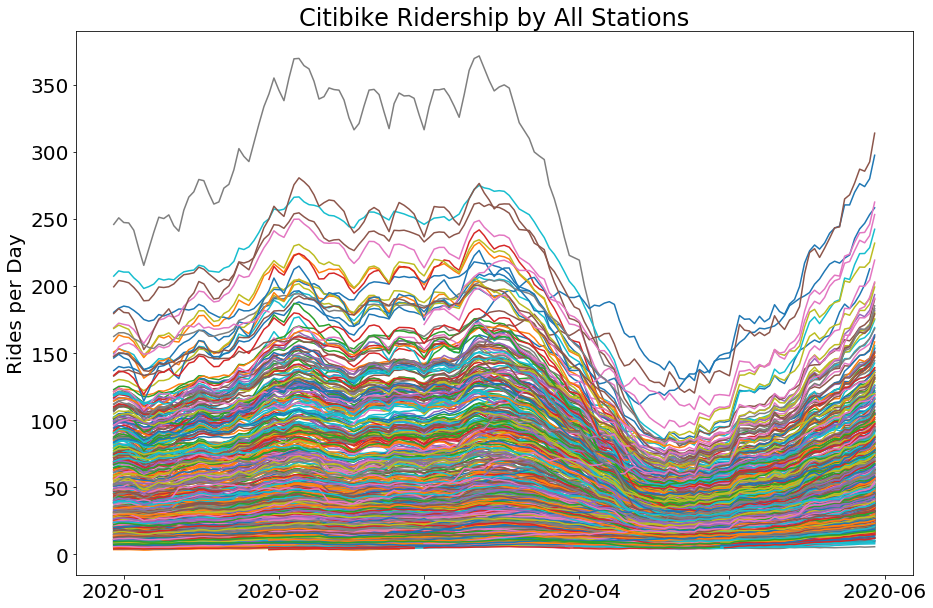

In [12]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(15,10))

for name in station_names:
    plt.plot(bike_df.iloc[697:878][name].rolling(window=30).mean())
    
plt.title('Citibike Ridership by All Stations')
#ax.set_xlabel('Longitude')
ax.set_ylabel('Rides per Day')

## 

In [6]:
#Citibike data is very volatile, due to weather and such, so smooth it for a fair and less noisy comparison

smoothed=bike_df.rolling(window=30).mean()
year_to_year=smoothed
for name in station_names:
    year_to_year[name]=(bike_df[name]-smoothed[name].shift(365))/smoothed[name].shift(365)

    
    

Text(0, 0.5, 'Proportional Growth Since Previous Year')

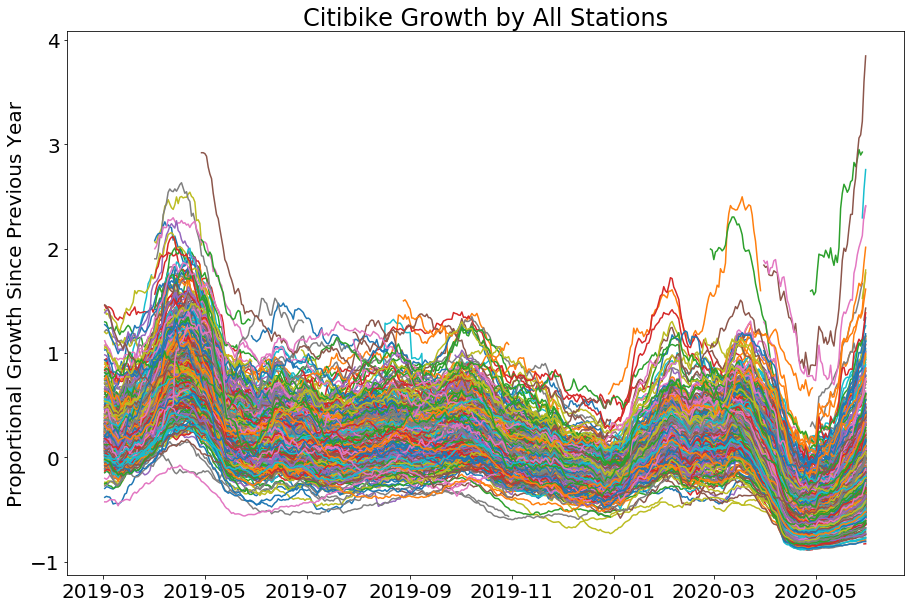

In [7]:

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(15,10))

for name in station_names:
    plt.plot(year_to_year[name].rolling(window=30).mean())

plt.title('Citibike Growth by All Stations')
#ax.set_xlabel('Longitude')
ax.set_ylabel('Proportional Growth Since Previous Year')

In [7]:

daily_mapper=pd.DataFrame()
daily_mapper['station']=station_locations['station']
daily_mapper['latitude']=station_locations['latitude']
daily_mapper['longitude']=station_locations['longitude']
dates=list(year_to_year.index)
for date in dates:
    daily_mapper[date]=year_to_year.loc[date].reset_index()[date]


In [12]:
import seaborn as sns

In [8]:
#throw out some obvious outliers that are messing up my plots
new=daily_mapper[(daily_mapper['latitude'] < 41) & (daily_mapper['longitude'] < -73.85)]

In [103]:
def col_calc(growth):
    red=0
    green=min(((growth+1.01)/3),1.0)
    blue=min((0.5+0.5*green),1.0)
    alpha=min((0.4+0.2*green),1.0)
    return(red,green,blue,alpha)

In [109]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
img = plt.imread("nyc.png")

i=365
for date in dates[878:879:]:
    print(date)
    color_series=new[date].apply(col_calc)
    fig, ax = plt.subplots(figsize=(9,14))
    ax.imshow(img, interpolation='bicubic', extent=[-74.03, -73.90, 40.63, 40.87])
    plt.scatter(x = new['longitude'], 
              y = new['latitude'],
              s = (new[date]+1)*100,
              color  = color_series,
              linewidth=0)
    plt.title('Citibike Growth since Previous\nYear by Station '+str(date))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticks([-74.03,-73.97,-73.91])
    filename='./images/step'+str(i)+'.png'
    plt.savefig(filename, transparent=True, dpi=96)
    plt.close('all')
    i+=1

2020-05-31


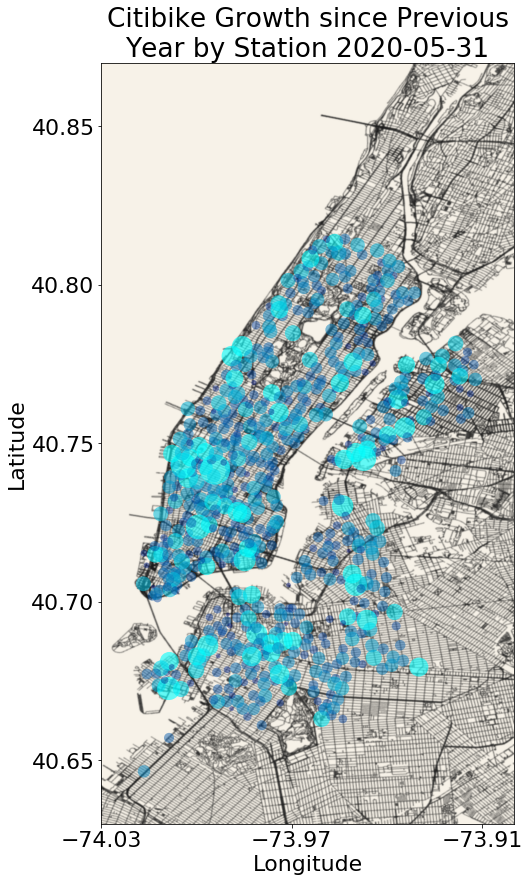

In [104]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 22})
img = plt.imread("nyc.png")
date=dates[878]
color_series=new[date].apply(col_calc)
fig, ax = plt.subplots(figsize=(9,14))
ax.imshow(img, interpolation='bicubic', extent=[-74.03, -73.90, 40.63, 40.87])
plt.scatter(x = new['longitude'], 
              y = new['latitude'],
              s = (new[date]+1)*100,
              color  = color_series,
              linewidth=0)
plt.title('Citibike Growth since Previous\nYear by Station '+str(date))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_xticks([-74.03,-73.97,-73.91])